# Feedforward Neural Network

In [1]:
import pickle
import time
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from matplotlib import pyplot as plt
import math

from lstm_data_prep import numpy_prep
from eval_model import accuracy, find_lens
from rnn_perm_test import create_permutation_3d, generate_random_features

In [2]:
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

X_train, y_train, X_test, y_test = numpy_prep(TS, pad = 0.)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()
X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

c:\Users\Anna&Megan\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr), pad=pad)


In [3]:
class FF(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_outputs):
    super().__init__()
    self.in_layer = nn.Linear(n_inputs, n_hidden)
    self.out_layer = nn.Linear(n_hidden, n_outputs)

  def forward(self, x):
    y = self.in_layer(x)
    y = self.out_layer(y)

    return y

In [4]:
def train(model, loss_fn, train_data, train_labels, n_epochs=500, learning_rate=1e-3):
  optimizer = optim.Adam(model.parameters(), lr=learning_rate)
  train_loss = []
  for i in range(n_epochs):
    out = model(train_data)

    output = torch.transpose(out, 1, 2)
    y = torch.transpose(train_labels, 1, 2)
    loss = loss_fn(output, y)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    if (i + 1) % (n_epochs // 5) == 0:
      print(f'iteration {i + 1}/{n_epochs} | loss: {loss.item():.3f}')

  return train_loss

EPOCHS = 500
n_input = 300
n_hidden = 103
n_output = 15

model = FF(n_input, n_hidden, n_output)

loss_fn = nn.CrossEntropyLoss()

train_loss = train(model, loss_fn, X_train, y_train, n_epochs=EPOCHS)

iteration 100/500 | loss: 2.318
iteration 200/500 | loss: 2.309
iteration 300/500 | loss: 2.309
iteration 400/500 | loss: 2.309
iteration 500/500 | loss: 2.310


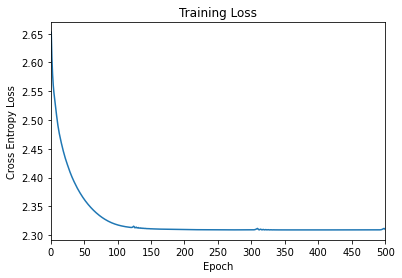

In [5]:
xAx = [i for i in range(1, EPOCHS+1)]
plt.plot(xAx, train_loss)
plt.xlabel("Epoch")
plt.ylabel("Cross Entropy Loss")
plt.xlim(0, EPOCHS)
plt.xticks([50*j for j in range(0, EPOCHS // 50 + 1)])
plt.title("Training Loss")
plt.show()

In [6]:
def eval(model, loss_fn, test_data, test_labels, seq_len):
    out = model(test_data)
    loss = loss_fn(out, test_labels)
    top_value, top_index = out.topk(1)

    final = torch.zeros(test_data.shape)
    for clip in range(test_data.shape[0]):
        for step in range(test_data.shape[1]):
            final[clip][step][top_index[clip][step]] = 1
    
    
    correct = np.zeros(seq_len)
    total = np.zeros(seq_len)

    correct, total = accuracy(test_labels.numpy(), final.numpy(), correct, total)
    ff_accuracy = correct / total
    return ff_accuracy, loss.item()

In [7]:
ff_accuracy, loss = eval(model, loss_fn, X_test, y_test, 90)

In [9]:
random_accs = []
for i in range(20):
    X_rand = generate_random_features([90 for i in range(X_test.shape[0])], X_test.shape[0])
    ff_random, loss_random = eval(model, loss_fn, torch.from_numpy(X_rand).float(), y_test, 90)
    random_accs.append(ff_random)



In [25]:
random_accs = np.array(random_accs)

random_accs.sort(axis=0)
row = math.floor(random_accs.shape[0] * 0.9)
plot = random_accs[row, :]

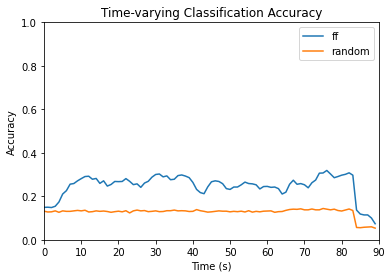

In [26]:
xAx = [i for i in range(0,90)]
plt.plot(xAx, ff_accuracy, label="ff")
plt.plot(xAx, plot, label="random")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,90)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()